# RFSoC Introduction

In this series of notebooks, we will introduce the RFSoC hardware and RFSoC relevant transmitter frequency bands. This will be done in three sections:

- An overview of the RFSoC device hardware
- [Frequency bands and Spectrum](./FrequencyBands.ipynb)
- Transmitter Safety

# RFSoC Device Overview

This first notebook will be focused around the  architecture of the RFSoC hardware. The RFSoC is a Zynq System on Chip (SoC) targeted specifically at RF applications. It features a Processing System (PS), Programmable Logic (PL) and specialist RF resources. 

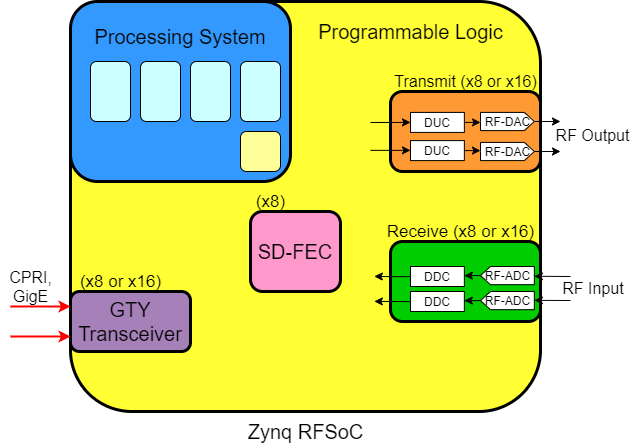

*Picture of our RFSoC?*

The specialist RF resources included in the RFSoC are:

- **Transmit Blocks**: 8 or 16 very high rate RF Digital to Analogue Converters (RF-DACs). These blocks also include Digital Up Converters (DUCs) for increasing the sampling rate and performing modulation. 


- **Receive blocks**: 8 or 16 very high rate RF Analogue-to-Digital (RF-ADCs). These blocks feature Digital Down Converters (DDCs) for demodulating the received signal and then reducing the sampling rate.


- **Soft Decision Forward Error Correction (SD-FEC) blocks**: 8 blocks for FEC encoding and/or decoding. These blocks support FEC coding schemes that are commonly used in 4G and 5G mobile standards.

There are also hardened resources for high speed wired communications, in the form of GTY Transceiver blocks. These blocks are commonly required for backhaul in wireless networks, namely CPRI (Common Public Radio Interface) and GigE (Gigabit Ethernet).

A general overview of the RFSoC device family can be seen from the Xilinx product page:

https://www.xilinx.com/products/silicon-devices/soc/rfsoc.html#ProductTable

## Notable Features

The RFSoC device has a number of notable features which separate it from a traditional radio transceiver.

**Single Chip Integration**

The RFSoC integrates DACs and ADCs into the same chip as the processing resources needed to implement a radio transceiver.  

Other solutions require at least 2 chips e.g. a Zynq/Zynq MPSoC for signal processing paired with a front-end radio transceiver for modulating and demodulating the signal to and from its target RF Frequency. 

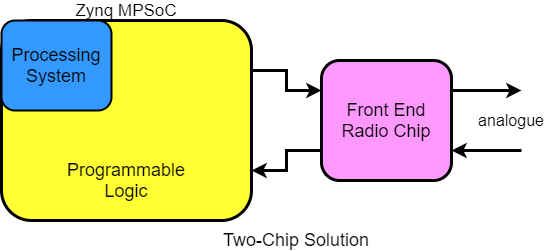


As a result, the RF interface ports of the RFSoC development board can be connected directly to analogue components to build a complete radio system. 

**High Sample Rate**

The RF-ADCs and RF-DACs are both capable of sampling at multiple GHz, providing a very wide RF bandwidth. The RFSoC can directly digitise an RF band from 0 to 2 GHz. 

*Want a simple demo in here of spectrum analyser, to show this wide bandwidth in action.*

*Is a comparison between RFSoC and much narrower SDR chip possible?*


**Multiple Channels**

Each RFSoC device has multiple channels (8 or 16) of transmit and receive functionality. These have a number of uses, including:

- Multiple Input Multiple Output (MIMO) systems
- Beamforming/Beamsteering

MIMO introduces spatial diversity to improve the throughput achievable over a link as there are multiple transmitters and multiple receivers involved, each with a different position in space.

*What can we do in the way of a MIMO/beamforming demo? Is there a notebook that demonstrates this?*

*if not just use Massive MIMO diagram?*

Aside from these multi-antenna systems, the 8 or 16 channels of the RFSoC can also be used to support multiple different transmit and receive paths of the same or different radio standards on the same chip. This compares favourably to a conventional solution where several chips would be required. 

## PS Architecture

The RFSoC's Processing System (PS) includes several different types of processing resources. These can be used to implement the software-based aspects of a transmission/receiver system. These resources include:

- **External Interfaces**: local IoT devices, SDR backhaul, networked system control.


- **Platform Management and security functions**: system booting, power management, physical security, SDR comms security.


- **Dual-core Arm Cortex-R5 real-time processor**: low level, deterministic SDR system control and orchestration.


- **PS local memories, external memory control**: Software programs, SDR instructions and data


- **Quad-core Arm Cortex-A53 applications processor**: running operating system, SDR software applications


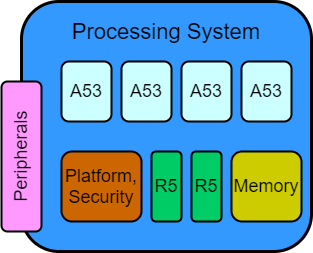

The four Arm Cortex-A53 processors are capable of running a fully featured Operating System and software applications. In the examples in this course the PYNQ software framework is deployed on the applications processor. More details on PYNQ can be found here: http://www.pynq.io/

## PL Architecture 

The Programmable Logic of the RFSoC is equivalent to that of an FPGA. Most devices in the RFSoC family provide a standard set of resources, including:

- High speed, wired interfaces (GTY transceivers, PCIe, 150G Interlaken, 100G Ethernet)


- Configurable Logic Blocks (930K logic cells)


- DSP Slices (4272)


- Block RAM (38 Mb)


- Ultra RAM (22.5 Mb)


AXI PS-to-PL interconnections enable control and data to pass quickly between the software and hardware systems.

The PL is where the hardware design will be created. The parallel, programmable nature of the PL is ideal for implementing Digital Signal Processing (DSP) for the physical layer of transmitter and receivers. Hardware subsystems can be designed for flexible operation, programmed from software.

## Data Converters

There are two types of RF Data Converters on the RFSoC:

**Transmit side**: An RF-DAC and Digital Up-Converter (DUC). The Interpolators, NCO and sampling rate are programmable. 

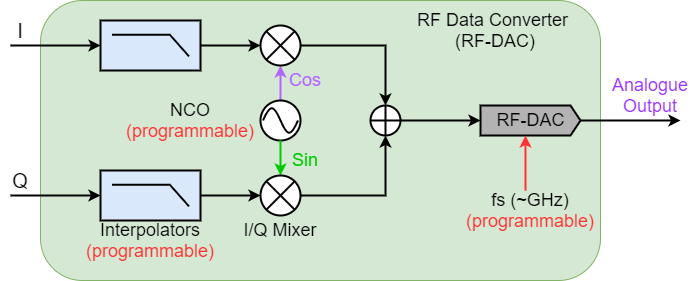

**Receive side**: An RF-ADC and Digital Down-Converter (DDC), likewise programmable. 

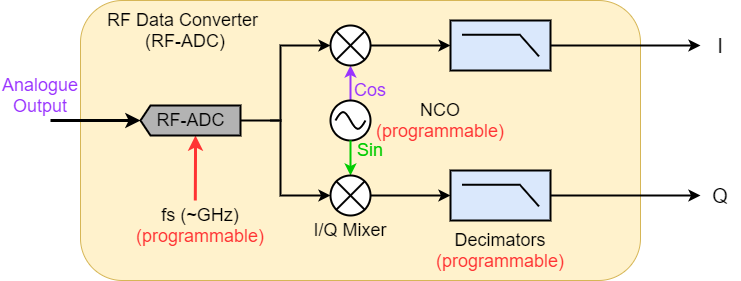

A notable benefit to the RFSoC is the highly programmable nature of the RF Data Converters:

- The sampling rates for the RF-DACs and RF-ADCs are programmable, with maximum and minimum values depending on the RFSoC Generation. For Gen 1, the RF-DACs can operate at sample rates of up to 6.554 Gsps, and the RF-ADCs can operate at up to 4.096 Gsps.


- The NCO frequency is programmable. When the standard operating mode is used, it represents the RF frequency that the baseband signal is modulated to, and demodulated from.


- The Interpolators and decimators can be programmed to undertake rate changes of 1 (no rate change), 2, 4 and 8, respectively. Further rate interpolation or decimation can be implemented in the PL.

## Data Converter Hierarchy

The architecture and hierarchy of the RF-ADCs and RF-DACs are key to the RFSoC design and as such will now be considered in more detail. 

### RF-ADC Hierarchy

**RF-ADCs as tiles**

RFSoC devices have either 8 or 16 RF-ADCs, grouped into tiles alongside mixers and decimators.

There are two different tile configurations:

- Dual RF-ADC tiles: 2x RF-ADCs, 2x mixers, 2x decimators
- Quad RF-ADC tiles: 4x RF-ADCs, 4x mixers, 4x decimators

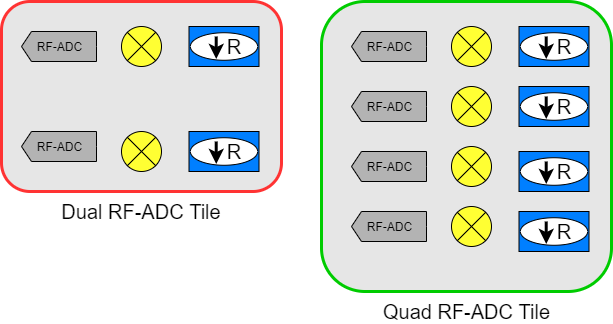

Each RF-ADC tile includes its own Phase Locked Loop (PLL) for managing the sampling clock applied to the RF-ADCs. 

The RFSoC's RF-ADCs comprise multiple interleaved sub-ADCs, all sampling at a lower rate. In combination, these can achieve a sampling rate of up to 5 Gsps.

**Dual RF-ADC Tile**

A dual RF-ADC tile supports two RF input channels:

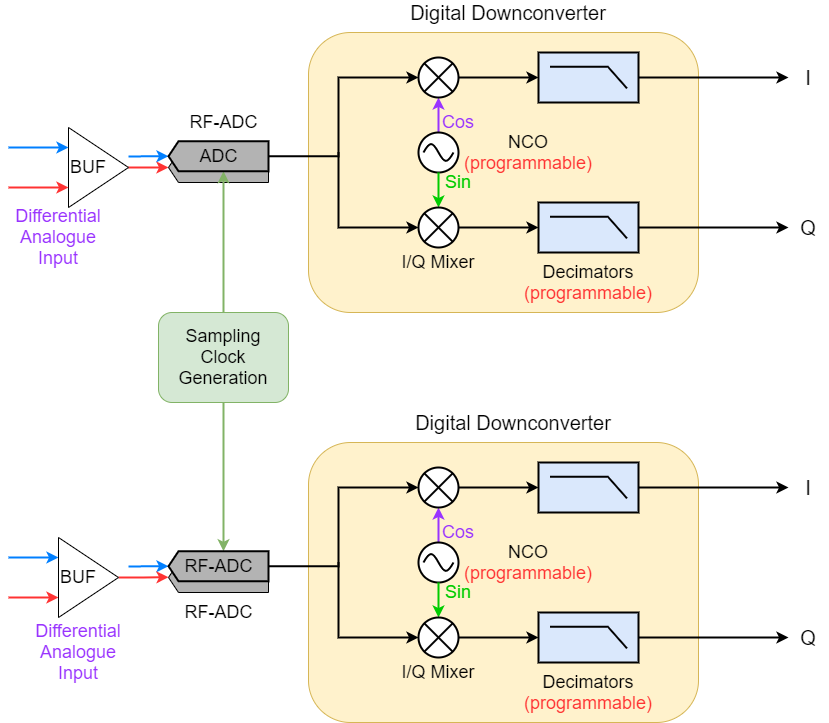

RF-ADCs can operate in two modes:

- **Real-to-Complex**: An RF channel is input to the RF Data Converter as a real signal, and is thereafter mixed with the output of a complex Numerically Controlled Oscillator (NCO) to form a complex (I/Q) output. The upper and lower halves of the tile can each handle one input RF signal in this manner, and therefore the Dual RF-ADC tile can support two RF channels.


- **Complex-to-Complex**: An RF channel is input to the RF Data Converter as a complex signal (I/Q), and is then mixed using a complex oscillator to form a complex output (also I/Q). In this configuration, both RF-ADCs are required - one for the analogue I input and another for the analogue Q output. Consequently, in this mode, a Dual RF-ADC tile can only support one RF channel.

The user has a number of programmable options when operating Dual RF-ADC Tiles:

- Operating mode (Real-to-Complex or Complex-to-Complex)


- RF-ADC sampling frequency


- Mixer mode (course or fine)


- Mixer NCO frequency


- Decimation ratio (1x, 2x, 4x, 8x) - note that 1x simply involves bypassing the decimator


Signals are demodulated using the complex NCO and decimated using the integrated decimator. Both of the RF-ADCs within the tile share the same clocking infrastructure, enabling synchronous sampling.

*Can we demonstrate either/both of the operating modes?*

**Quad RF-ADC Tile**

A Quad RF-ADC tile comprises four RF-ADCs, arranged in two pairs.

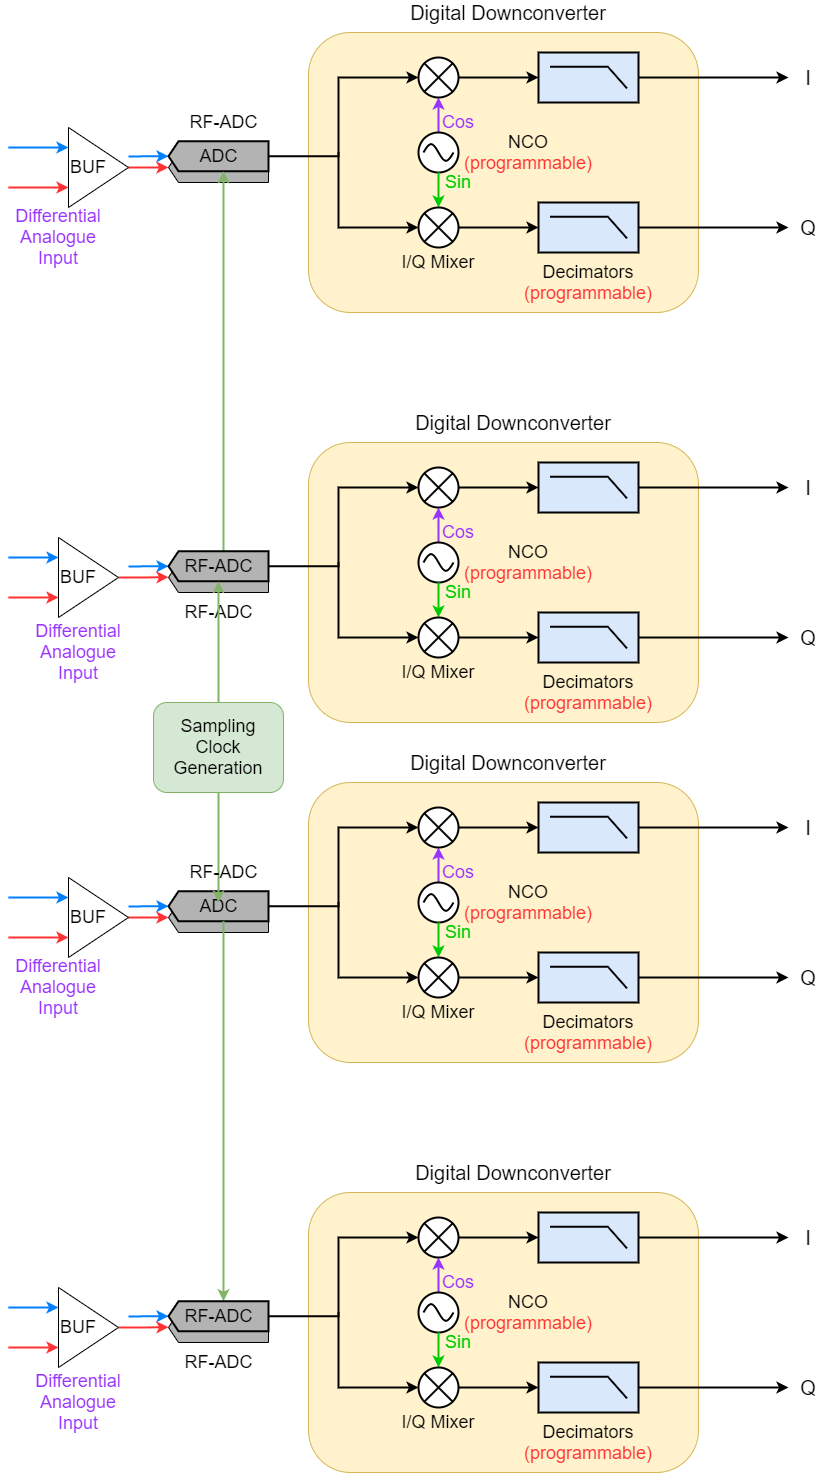


A quad RF-ADC tile is equivalent to two Dual RF-ADC tiles. One advantage that it has over the Dual RF-ADC is its ability to support multiple bands (i.e. spectrally separated signals). The Quad can support up to four bands, the Dual, two.

Multiple bands can be received simultaneously by routing the sampled RF input signal to more than one different mixing and decimation stage within the tile. As there are two mixers and two decimators with the Dual RF-ADC it can support two bands simultaneously, whereas the Quad RF-ADC can support up to four bands using four mixers and four decimators.

*what can be done in the way of demonstration of multi band receiver?*

**DDC: Digital I/Q Mixer**

The digital I/Q mixer multiplies the incoming signal with sine and cosine waves, generated by an NCO. This has the effect of shifting the input signal up or down in frequency. This works to demodulate the received signal, shifting it to a baseband frequency. 

Learn more about modulation and demodulation from this [notebook](./Modulation_Demodulation.ipynb).

**I/Q Mixer Modes**

The I/Q Mixer can operate in 3 modes: **Coarse**, **Fine** and **Bypass**.

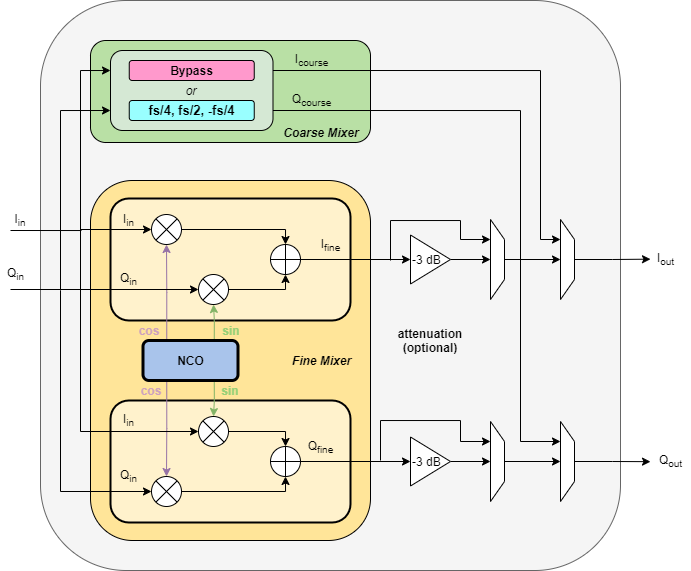

The **Coarse Mixer** component implements both the **Coarse** mode and the **Bypass** mode.

- In **Coarse** mode, the mixer is able to demodulate using only a very restricted set of frequencies, however it is able to operate in this mode with lower power than in Fine mode. This is because sine and cosine waves at these frequencies comprise a very limited set of samples.


- In **Bypass** mode, the signal path simply bypasses the I/Q mixing stage, via the coarse stage, and does not undergo any modulation/demodulation.

Frequencies of $\frac{f_{s}}{4}$ and $-\frac{f_{s}}{4}$ are useful for modulating/demodulating to a quarter of the sampling frequency with absolutely minimal cost. The NCO must generate only four samples per sine wave cycle: 0, +1, 0, -1. It is trivial to store these values and to multiply another signal by them for modulation/demodulating. 

*Code to show this simple sine wave*

Multiplying by 0, +1 and -1 is trivial, and therefore the modulator or demodulator architecture can be simplified to a counter and some simple combinatorial logic, as shown.

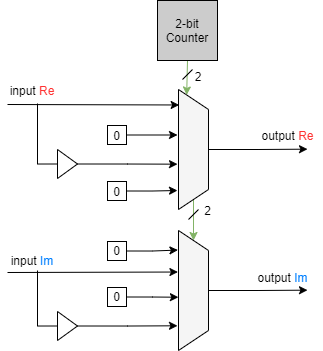


This same principle can be implemented to demodulate with $\frac{f_{s}}{2}$ as well.

The **Fine Mixer** component implements **Fine** mode.

- In **Fine** mode, the mixer uses an NCO, which can generate any arbitrary frequency between $-\frac{f_{s}}{2}$ and $\frac{f_{s}}{2}$. This is done by setting a step size input to the phase accumulator (automatically calculated in the design tools), the lookup table size and the desired frequency. Optional additional parameters can be set, including a phase adjustment and added dithering.

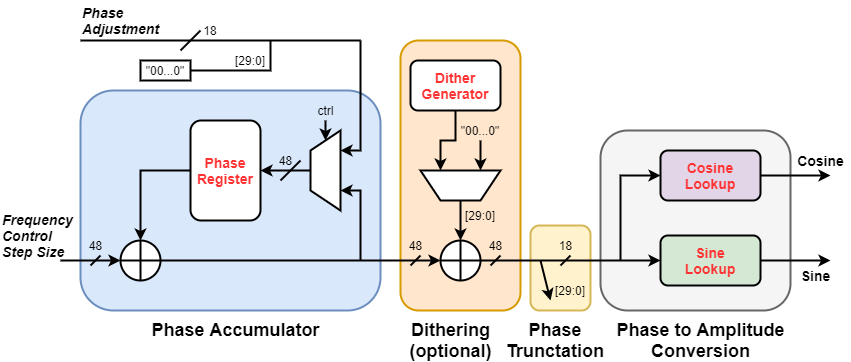

**DDC: Programmable Decimator**

The decimator can perform rate reduction by a factor of: 1x, 2x, 4x, or 8x.

Decimation is achieved by a set of half-band filters: FIR0, FIR1, and FIR2. These low pass filters each decimate by a factor of 2, and are cascaded together to form  the selection of outputs shown below:

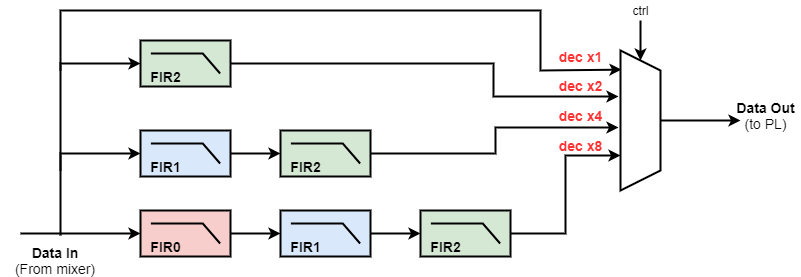

*Are we able to show some filter outputs in code?*

**Active Gain Control**

Active Gain Control (AGC) is an adaptive method for adjusting the gain applied to the input signal of an ADC, in order to scale the voltage to match the full scale of the ADC.

In RFSoC, the AGC algorithm is user-designed in the PL, and controls an external Variable Gain Amplifier.

### RF-DAC Hierarchy

The RF-DACs are grouped in a similar fashion to RF-ADCs. The main difference is that RF-DACs are available only in Quad tiles, i.e. there are always four RF-DAC blocks per tile. 

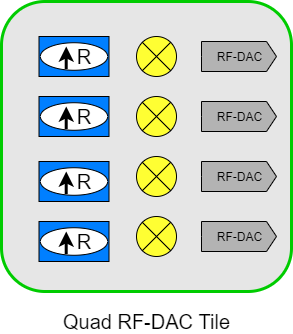

RF-DAC blocks can be configured individually, to produce real output signals, or as a pair, to produce complex output signals.

Each RF-DAC block contains a programmable interpolator, an I/Q mixer, and the RF-DAC data converter. 

**RF-DAC Programmable Interpolator**

The programmable interpolator supports ratios of 1x, 2x, 4x, and 8x. An interpolation by 1 means that the filters are bypassed.

The programmable interpolators are composed of three halfband filters, FIR0, FIR1 and FIR2. The path taken through the filters depends on the chosen interpolation ratios. This structure is very similar to that used in the RF-ADC's programmable decimator, but notice that the order of the filters differs. The specification of the individual filters is the same as in the RF-ADC. 

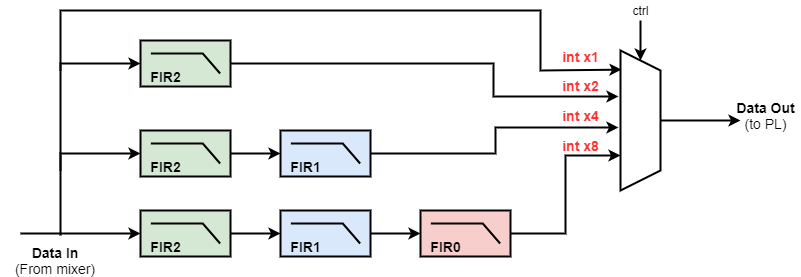

## SD-FEC Blocks

FEC coding and decoding are computationally intensive processes, particularly for the codes adopted in 4G and 5G radio systems. The Soft Decision (SD)-FEC core in the RFSoC supports the following modes of operation:

- Low Density Parity Check (**LDPC**) coding


- **LDPC** decoding


- **Turbo** decoding

Both LDPC and Turbo codes are high performance coding schemes that have been adopted in modern communication standards. Turbo codes are used in 3G and 4G Long Term Evolution (LTE). LDPC codes are used in 5G, providing even better error correction performance.

Selected RFSoC chips provide 8 hard SD-FEC cores. Soft SD-FEC cores can also be implemented in the PL if desired.

Learn more about SD-FEC from this notebook: *Link to notebook*

Click here to continue to the next section: [Frequency bands and Spectrum](./FrequencyBands.ipynb).

University Of Strathclyde &copy;